### Questions vs Statements Classification
https://www.kaggle.com/shahrukhkhan/questions-vs-statementsclassificationdataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.options.display.max_columns = None
np.set_printoptions(suppress=True)

import warnings
warnings.filterwarnings('ignore')

In [2]:
TRAIN_DATASET_PATH = './datasets/train.csv'
VALID_DATASET_PATH = './datasets/val.csv'
TEST_DATASET_PATH = './datasets/test.csv'

In [3]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, index_col=0)
train_df.head()

,doc,target
0,"For the rest of February, the Americans pushe...",0
1,During the second half of the 19th century Dut...,1
2,When did Egyptians start to make red pigment?,1
3,"In a 2012 report, the National Center for Sta...",0
4,What is an acceptable grounds for divorce for ...,1


In [4]:
train_df.shape

(126909, 2)

In [5]:
train_df.target.value_counts(normalize=True)

1    0.620137
0    0.379863
Name: target, dtype: float64

In [6]:
valid_df = pd.read_csv(VALID_DATASET_PATH, index_col=0)
valid_df.head()

,doc,target
0,How many did snow fall in Palermo between 1940...,1
1,When did the Egyptian and Syrian armies launch...,1
2,"Still, the political ramifications of removin...",0
3,What did Simpson help construct with Bell?,1
4,How much did 1941 earn in the US,1


In [7]:
valid_df.shape

(42303, 2)

In [8]:
valid_df.target.value_counts(normalize=True)

1    0.617119
0    0.382881
Name: target, dtype: float64

In [9]:
test_df = pd.read_csv(TEST_DATASET_PATH, index_col=0)
test_df.head()

,doc,target
0,What position did Napoleon III appoint to La V...,1
1,In the mid-1980s Lucasfilm pioneered the EditD...,0
2,Though the initially public details of the ag...,0
3,"After the reunification, the Südharzrevier wa...",0
4,Some scientists have hypothesized that the in...,0


In [10]:
test_df.target.value_counts(normalize=True)

1    0.619294
0    0.380706
Name: target, dtype: float64

In [11]:
X_train = train_df['doc']
y_train = train_df['target']
X_valid = valid_df['doc']
y_valid = valid_df['target']

In [12]:
X_test = test_df['doc']
y_test = test_df['target']

In [13]:
X_train.head()

0     For the rest of February, the Americans pushe...
1    During the second half of the 19th century Dut...
2        When did Egyptians start to make red pigment?
3     In a 2012 report, the National Center for Sta...
4    What is an acceptable grounds for divorce for ...
Name: doc, dtype: object

In [14]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import xgboost as xgb

In [15]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

In [16]:
pipeline = Pipeline([ 
                     ('doc_tfidf', TfidfVectorizer(stop_words='english' , max_features= 1000)), 
                     ('clf', xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss'))
                    ])

In [17]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('doc_tfidf',
                 TfidfVectorizer(max_features=1000, stop_words='english')),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='logloss',
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [18]:
y_preds = pipeline.predict(X_valid)

In [19]:
from sklearn.metrics import roc_auc_score, classification_report

In [20]:
roc_auc_score(y_valid, y_preds)

0.6110756023141695

In [21]:
target_names = ['statement', 'question']
print(classification_report(y_valid, y_preds, target_names=target_names))

              precision    recall  f1-score   support

   statement       0.67      0.32      0.43     16197
    question       0.68      0.90      0.78     26106

    accuracy                           0.68     42303
   macro avg       0.67      0.61      0.60     42303
weighted avg       0.68      0.68      0.64     42303



In [22]:
y_score = pipeline.predict_proba(X_valid)

In [23]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [24]:
precision, recall, thresholds = precision_recall_curve(y_valid, y_score[:,1])

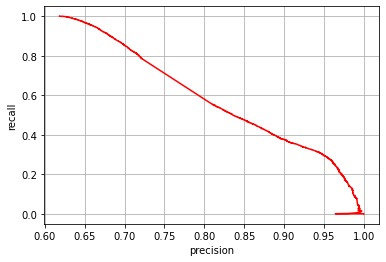

In [25]:
plt.plot(precision, recall,'-r')
plt.grid('On')
plt.xlabel('precision')
plt.ylabel('recall')
plt.show()

In [26]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.452570, F-Score=0.780, Precision=0.665, Recall=0.944


In [27]:
from itertools import product
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 3757 12440]
 [ 1450 24656]]


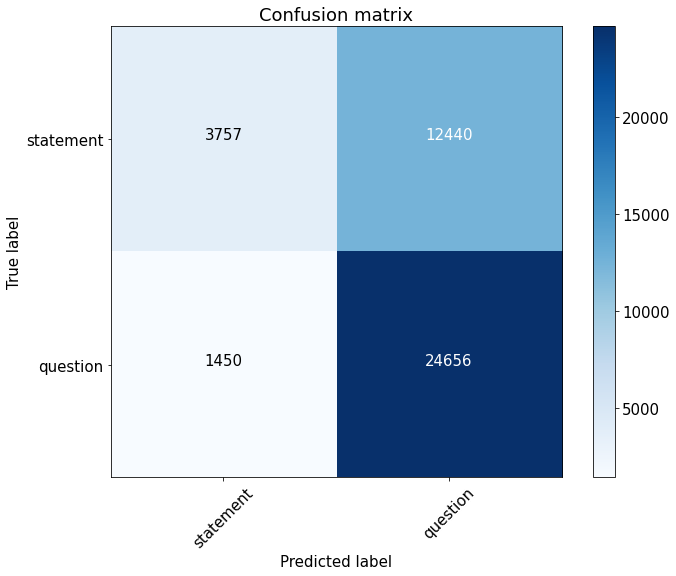

In [28]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_valid, y_score[:,1]>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['statement', 'question'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [33]:
from sklearn.model_selection import GridSearchCV

params={'clf__n_estimators':[100, 150, 200, 250, 300],
        'clf__learning_rate':[0.1, 0.05, 0.01],
        'clf__max_depth':[3, 5, 7, 10, 15, 20],
        'clf__subsample': [0.5, 0.7, 0.9, 1],
        'clf__tree_method': ['gpu_hist']
        }

In [35]:
grids = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=10,
                    refit=False)

In [36]:
%%time
search = grids.fit(X_train, y_train)

Wall time: 12h 47min 45s


In [37]:
search.best_params_

{'clf__learning_rate': 0.01,
 'clf__max_depth': 3,
 'clf__n_estimators': 200,
 'clf__subsample': 1,
 'clf__tree_method': 'gpu_hist'}

In [38]:
search.best_score_

0.6201451435928206